# Unconditional

In [8]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_palette(sns.color_palette("Spectral"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings

import matplotlib.colors as mcolors
import numpy as np

warnings.filterwarnings("ignore")

length_list = [100, 200, 300, 400, 500]
cmap = sns.color_palette("Spectral", as_cmap=True)
color_list = cmap(np.linspace(0, 1, cmap.N))
interval = len(color_list) // len(length_list)
start = interval * 1
end = len(color_list) - interval * 0
step = (end - start) // len(length_list)
color_list = [color_list[idx] for idx in range(start, end, step)]

custom_palette = [mcolors.rgb2hex(c) for c in color_list]
custom_palette[0] = "#f9633d"
custom_palette[2] = "#fceec9"
custom_palette[4] = "#5fb1a5"


def load_top_samples(eval_dir, index=-2):
    dfs = []
    import glob

    for path in glob.glob(eval_dir + "/**/eval/all_top_samples.csv"):
        length = int(path.split("/")[-3].split("_")[index])
        if length not in length_list:
            continue
        df = pd.read_csv(path)
        df["length"] = length
        dfs.append(df)
    df_cat = pd.concat(dfs)
    df_cat = df_cat.sort_values("length")
    return df_cat


def load_designable(eval_dir, index=-2):
    dfs = []
    for path in glob.glob(eval_dir + "/**/eval/designable.csv"):
        length = int(path.split("/")[-3].split("_")[index])
        if length not in length_list:
            continue
        df = pd.read_csv(path)
        df["length"] = length
        dfs.append(df)
    df_cat = pd.concat(dfs)
    df_cat = df_cat.sort_values("length")
    df_cat["diversity"] = df_cat["Clusters"]
    return df_cat

### plot

,Total codesignable,Designable,Total samples,Clusters,length,diversity
0,100,1.00,100,68,100,68
0,98,0.98,100,63,200,63
0,95,0.95,100,57,300,57
0,100,1.00,100,60,400,60
0,99,0.99,100,53,500,53


<Axes: xlabel='length', ylabel='Clusters'>

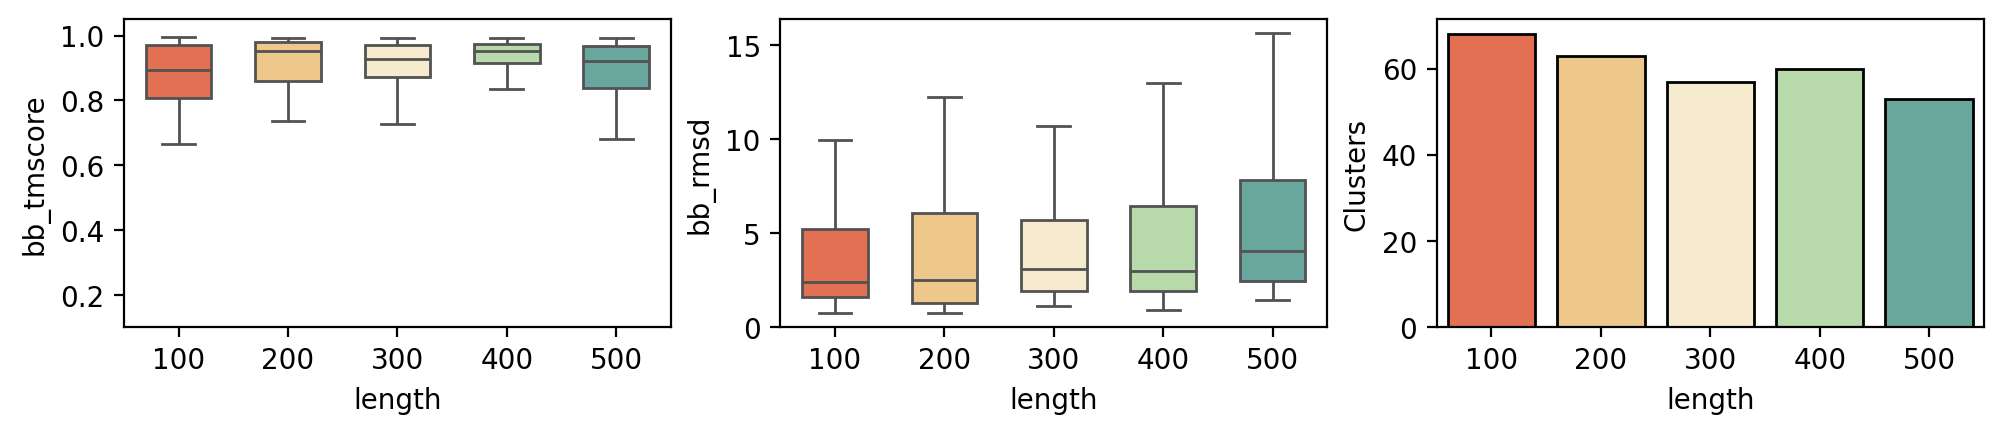

In [11]:
eval_dir = "./generation-results/dplm2_650m/co_generation/unconditional_codesign/run_2025-05-11_22-21-04"

index = -1
df_cat = load_top_samples(eval_dir, index=index)
fig, axes = plt.subplots(1, 3, figsize=(12, 2))

sns.boxplot(
    data=df_cat,
    y="bb_tmscore",
    x="length",
    ax=axes[0],
    showfliers=False,
    width=0.6,
    palette=custom_palette,
)
axes[0].set_ylim(0.1, 1.05)
sns.boxplot(
    data=df_cat,
    y="bb_rmsd",
    x="length",
    ax=axes[1],
    showfliers=False,
    width=0.6,
    palette=custom_palette,
)

df_cat_designable = load_designable(eval_dir, index=index)
display(df_cat_designable)
sns.barplot(
    x="length",
    y="Clusters",
    data=df_cat_designable,
    ax=axes[2],
    palette=custom_palette,
    edgecolor="black",
)

## Secondary Structure Analysis

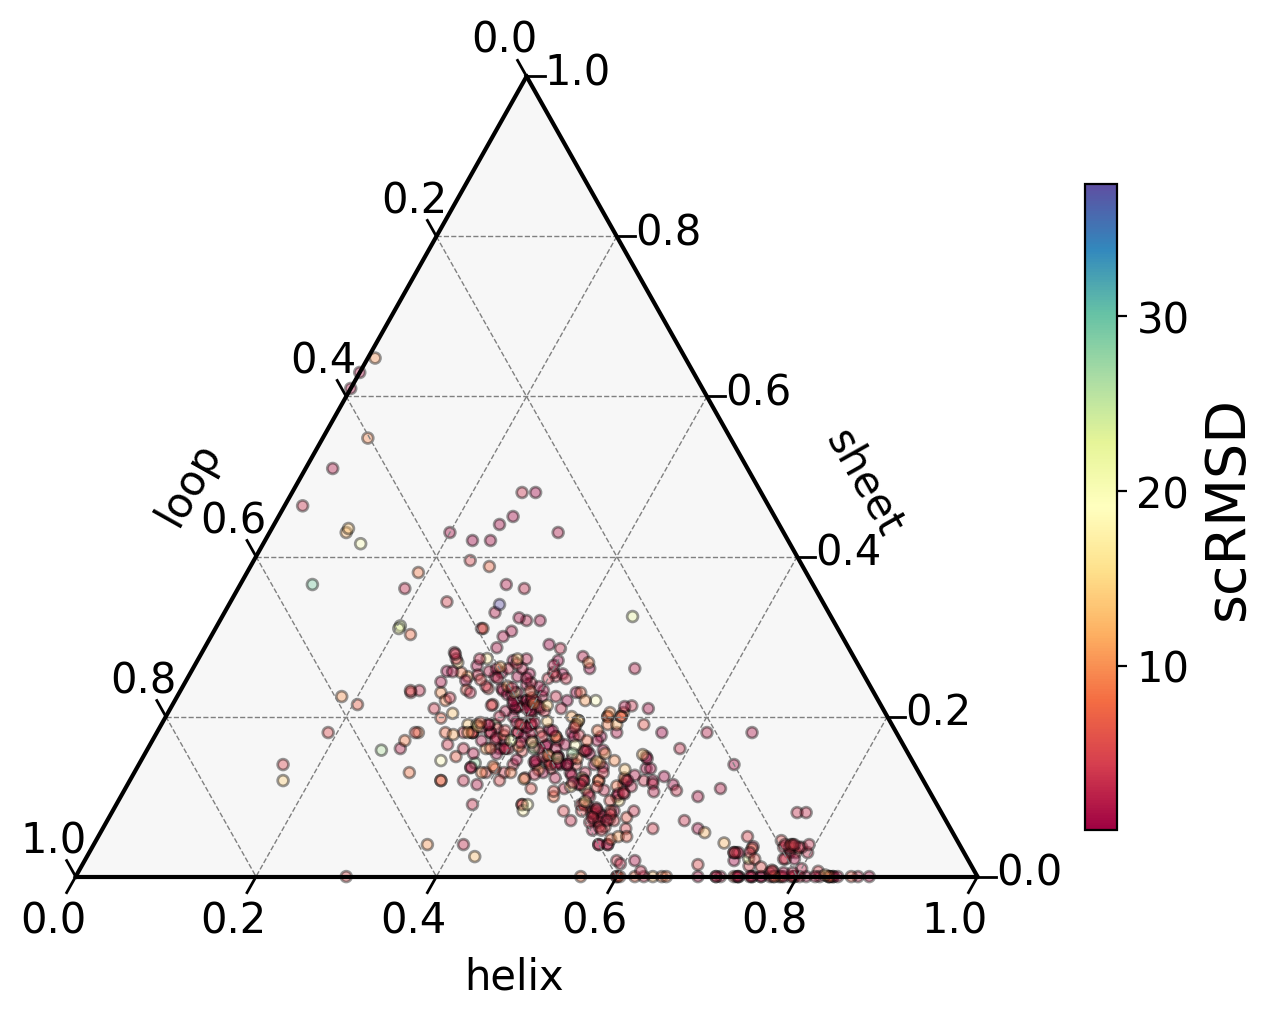

In [10]:
import ternary

df = df_cat

df["loop_percent"] = df.apply(
    lambda x: 1 - x["helix_percent"] - x["strand_percent"], axis=1
)

figure, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
tax = ternary.TernaryAxesSubplot(ax=ax, scale=1.0)

tax.gridlines(multiple=0.2, color="grey", linestyle="--")
tax.boundary(linewidth=1.5)
tax.ticks(
    axis="lbr",
    multiple=0.2,
    linewidth=1,
    offset=0.02,
    fontsize=15,
    tick_formats="%.1f",
)

tax.bottom_axis_label("helix", fontsize=15, offset=0.05)
tax.left_axis_label("loop", fontsize=15, offset=0.13)
tax.right_axis_label("sheet", fontsize=15, offset=0.13)

points = df[
    ["helix_percent", "strand_percent", "loop_percent"]
].values.tolist()
cmap = sns.color_palette("Spectral", as_cmap=True)
norm = plt.Normalize(df["bb_rmsd"].min(), df["bb_rmsd"].max())
colors = [cmap(norm(val)) for val in df["bb_rmsd"]]
tax.scatter(points, color=colors, marker="o", s=15, edgecolors="k", alpha=0.4)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = figure.colorbar(sm, ax=tax.ax, orientation="vertical", shrink=0.7)
cbar.set_label("scRMSD", fontsize=20, rotation=90)
cbar.ax.tick_params(labelsize=15)

tax.clear_matplotlib_ticks()
tax._redraw_labels()
plt.show()